In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import integrate

In [10]:
# set up grids
Ny = 140
Nx = 140
x = np.linspace(-2,2,Ny)
y = np.linspace(-2,2,Nx)
if np.any(y == 0):
    raise ValueError("Zero found in the y(r) coordinates")
X, Y = np.meshgrid(x, y)
rad_dist = np.sqrt(X**2 + Y**2)

# define parameters
alpha = 1
a = 1

# define streamfunctions
psi = np.empty_like(rad_dist)
psi[rad_dist < a] = alpha * (Y[rad_dist < a]**2) * (a**2 - rad_dist[rad_dist < a]**2) / 10
psi[rad_dist > a] = -alpha * (a**2) * (Y[rad_dist > a]**2) * (1 - a**3 / rad_dist[rad_dist > a]**3) / 15
# fig, ax = plt.subplots(layout='constrained')
# CS = ax.contour(X, Y, psi, 80, cmap='bwr')
# cbar = fig.colorbar(CS)

# define velocity fields
Uf = np.empty_like(psi)
Uf[rad_dist < a] = alpha * (a**2 - rad_dist[rad_dist < a]**2 - Y[rad_dist < a]**2) / 5
Uf[rad_dist > a] = -alpha * a**2 * ( 2*(1 - a**3 / rad_dist[rad_dist > a]**3) + 3*a**3*Y[rad_dist > a]**2/rad_dist[rad_dist > a]**3 ) / 15

Vf = np.empty_like(psi)
Vf[rad_dist < a] = alpha * X[rad_dist < a] * Y[rad_dist < a] / 5
Vf[rad_dist > a] = alpha* a**5 * Y[rad_dist > a] * X[rad_dist > a] / ( 5*(rad_dist[rad_dist > a] ** 3))


# Create a quiver plot to visualize the velocity field
# plt.figure(figsize=(6, 6))
# plt.quiver(X, Y, Uf, Vf, scale=40, color='b', headlength=3)
# plt.xlabel('x(z)')
# plt.ylabel('y(r)')
# plt.axis('equal')
# plt.show()


In [4]:
#### compute particle trajectories
t0 = 0
tf = 60

# Solve the IVP RK4 -- for FLUID particles
def solve_ivp_passive(r0, t0=t0, tf=tf):

      """
      argument r0 should be a LIST : [x0, y0]
      """

      # define the IVP to solve -- for FLUID particles
      t_span = np.linspace(t0,tf,500)

      def passive_tracer_traj(t, r):
            X, Y = r
            dist = np.sqrt(X**2 + Y**2)
            if dist <= a:
                  fx = alpha * (a**2 - dist**2 - Y**2) / 5
                  fy = alpha * X * Y / 5
            else :
                  fx = -alpha * a**2 * ( 2*(1 - a**3 / dist**3) + 3* a**3 * Y**2 / dist**3 ) / 15
                  fy = alpha* a**5 * Y * X/ ( 5*(dist ** 3))
            return [-fx, -fy]

      passive_sol = sp.integrate.solve_ivp(passive_tracer_traj, [t0,tf], r0, t_eval=t_span, vectorized=True)
      xt, yt = passive_sol.y
      return xt, yt


In [5]:
### compute the particle flow map in the whole domain

# create a flattened array of grid points, first index is x
grid_coords = np.column_stack((X.ravel(), Y.ravel()))
final_coords = np.empty_like(grid_coords, dtype=object)

# # loop through all lagrangian grid points to find final positions
# for i, point in enumerate(grid_coords):
#     r0 = [grid_coords[i, 0], grid_coords[i, 1]]
#     rt = solve_ivp_passive(r0, t0, tf)
#     final_coords[i,:] = [rt[k][-1] for k in [0,1]]

## using multiprocessing
'''
output [res], a list with len = Nx*Ny, 
each list element is an array of t_span for one particle
'''
from multiprocessing import Pool

n_proc = 12
with Pool(n_proc) as pool:
    args = list( grid_coords )
    res = pool.map( solve_ivp_passive, args )

final_coords = np.array([(point[0][-1], point[1][-1]) for point in res], dtype=float)



# flow map, each row has 4 entries [x0, y0, xf, yf]
flow_map = np.column_stack((grid_coords, final_coords))
np.save(f'hills_tf{tf}.npy', flow_map)



In [6]:

# this is a 3D array and the first two indicies are the particle "Name" (defined by its initial position)
flow_map_arr = np.array([tuple(row) for row in flow_map]).reshape((Ny, Nx, 4))
X0 = flow_map_arr[:,:,0]
Y0 = flow_map_arr[:,:,1]
Xf = flow_map_arr[:,:,2]
Yf = flow_map_arr[:,:,3]

In [7]:
def compute_ftle(xi, yj, t0, tf):

    D = np.zeros((2,2))   # 2D deformation gradient matrix
    D[0,0] = (Xf[yj, xi+1] - Xf[yj, xi-1]) / (X0[yj, xi+1] - X0[yj, xi-1])
    D[0,1] = (Xf[yj+1, xi] - Xf[yj-1, xi]) / (Y0[yj+1, xi] - Y0[yj-1, xi])
    D[1,0] = (Yf[yj, xi+1] - Yf[yj, xi-1]) / (X0[yj, xi+1] - X0[yj, xi-1])
    D[1,1] = (Yf[yj+1, xi] - Yf[yj-1, xi]) / (Y0[yj+1, xi] - Y0[yj-1, xi])

    # CGDtensor = D.T @ D # symmetric square real matrix must have orthogonal eigenvectors,  the SV's are the absolute values of the eigenvalues
    # _, SV, _ = np.linalg.svd(CGDtensor, hermitian=True)

    _, SV, _ = np.linalg.svd(D)

    if SV[0] < 1:
        SV = np.ones_like(SV)
    else:
        SV[1] = 1/SV[0]

    ftle = np.log(SV[0]) / np.abs(tf-t0)
    
    return ftle

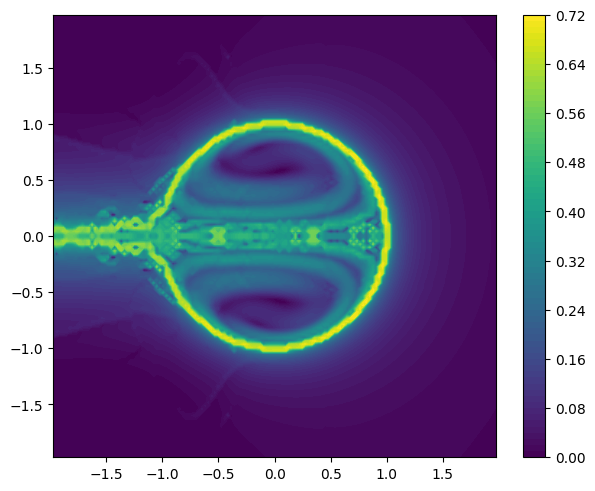

In [11]:
FTLE_field = np.empty((Ny-2, Nx-2))

for xi in range(Nx-2) :
    for yj in range(Ny-2) :
        FTLE_field[yj, xi] = compute_ftle((xi+1), (yj+1), t0=0, tf=7.5)

fig, ax = plt.subplots(layout='constrained')
CS = ax.contourf(X[1:-1, 1:-1], Y[1:-1, 1:-1], FTLE_field, 80)
ax.set_aspect('equal')
cbar = fig.colorbar(CS)